In [12]:
import nibabel
import matplotlib.pyplot as plt
import math
import random
import collections
import cv2
import numpy as np
import SimpleITK as sitk
from skimage.transform import resize

(array([[512.,   0.,   0., ...,   0.,   0.,   0.],
        [512.,   0.,   0., ...,   0.,   0.,   0.],
        [512.,   0.,   0., ...,   0.,   0.,   0.],
        ...,
        [512.,   0.,   0., ...,   0.,   0.,   0.],
        [512.,   0.,   0., ...,   0.,   0.,   0.],
        [512.,   0.,   0., ...,   0.,   0.,   0.]]),
 array([0. , 0.6, 1.2, 1.8, 2.4, 3. , 3.6, 4.2, 4.8, 5.4, 6. ]),
 <a list of 512 BarContainer objects>)

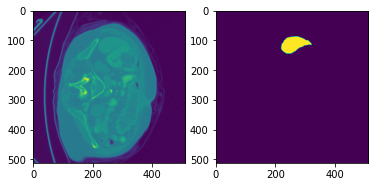

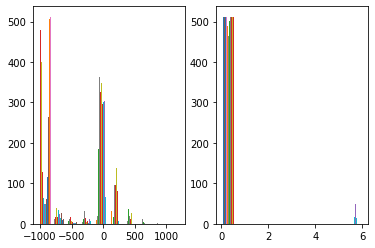

In [11]:
file_img = nibabel.load('img0001.nii.gz')
file_mask = nibabel.load('label0001.nii.gz')

img = file_img.get_fdata()
mask = file_mask.get_fdata()

plt.figure(0)

plt.subplot(1, 2, 1)
plt.imshow(img[:, :, 70])

plt.subplot(1, 2, 2)
plt.imshow(mask[:, :, 70])

plt.figure(1)

plt.subplot(1, 2, 1)
plt.hist(img[:, :, 70])

plt.subplot(1, 2, 2)
plt.hist(mask[:, :, 70])

In [50]:
crop_h = 256
crop_w = 256
crop_d = 100

def truncate(CT):
    min_HU = -325
    max_HU = 325
    subtract = 0
    divide = 325.

    # truncate
    CT[np.where(CT <= min_HU)] = min_HU
    CT[np.where(CT >= max_HU)] = max_HU
    CT = CT - subtract
    CT = CT / divide
    
    return CT

def id2trainId(label, task_id):
    if task_id == 0 or task_id == 1 or task_id == 3:
        organ = (label >= 1)
        tumor = (label == 2)
    elif task_id == 2:
        organ = (label == 1)
        tumor = (label == 2)
    elif task_id == 4 or task_id == 5:
        organ = None
        tumor = (label == 1)
    elif task_id == 6:
        organ = (label == 1)
        tumor = None
    else:
        print("Error, No such task!")
        return None

    shape = label.shape
    results_map = np.zeros((2, shape[0], shape[1], shape[2])).astype(np.float32)

    if organ is None:
        results_map[0, :, :, :] = results_map[0, :, :, :] - 1
    else:
        results_map[0, :, :, :] = np.where(organ, 1, 0)
    if tumor is None:
        results_map[1, :, :, :] = results_map[1, :, :, :] - 1
    else:
        results_map[1, :, :, :] = np.where(tumor, 1, 0)

    return results_map

def locate_bbx(label, scaler, bbx):
    scale_d = int(crop_d * scaler)
    scale_h = int(crop_h * scaler)
    scale_w = int(crop_w * scaler)

    img_h, img_w, img_d = label.shape
    boud_h, boud_w, boud_d = bbx
    margin = 32  # pixels

    bbx_h_min = boud_h.min()
    bbx_h_max = boud_h.max()
    
    bbx_w_min = boud_w.min()
    bbx_w_max = boud_w.max()
    
    bbx_d_min = boud_d.min()
    bbx_d_max = boud_d.max()
    
    if (bbx_h_max - bbx_h_min) <= scale_h:
        bbx_h_maxt = bbx_h_max + math.ceil((scale_h - (bbx_h_max - bbx_h_min)) / 2)
        bbx_h_mint = bbx_h_min - math.ceil((scale_h - (bbx_h_max - bbx_h_min)) / 2)
        if bbx_h_mint < 0:
            bbx_h_maxt -= bbx_h_mint
            bbx_h_mint = 0
        bbx_h_max = bbx_h_maxt
        bbx_h_min = bbx_h_mint
        
    if (bbx_w_max - bbx_w_min) <= scale_w:
        bbx_w_maxt = bbx_w_max + math.ceil((scale_w - (bbx_w_max - bbx_w_min)) / 2)
        bbx_w_mint = bbx_w_min - math.ceil((scale_w - (bbx_w_max - bbx_w_min)) / 2)
        if bbx_w_mint < 0:
            bbx_w_maxt -= bbx_w_mint
            bbx_w_mint = 0
        bbx_w_max = bbx_w_maxt
        bbx_w_min = bbx_w_mint
        
    if (bbx_d_max - bbx_d_min) <= scale_d:
        bbx_d_maxt = bbx_d_max + math.ceil((scale_d - (bbx_d_max - bbx_d_min)) / 2)
        bbx_d_mint = bbx_d_min - math.ceil((scale_d - (bbx_d_max - bbx_d_min)) / 2)
        if bbx_d_mint < 0:
            bbx_d_maxt -= bbx_d_mint
            bbx_d_mint = 0
        bbx_d_max = bbx_d_maxt
        bbx_d_min = bbx_d_mint
        
    bbx_h_min = np.max([bbx_h_min - margin, 0])
    bbx_h_max = np.min([bbx_h_max + margin, img_h])
    bbx_w_min = np.max([bbx_w_min - margin, 0])
    bbx_w_max = np.min([bbx_w_max + margin, img_w])
    bbx_d_min = np.max([bbx_d_min - margin, 0])
    bbx_d_max = np.min([bbx_d_max + margin, img_d])

    if random.random() < 0.8:
        d0 = random.randint(bbx_d_min, np.max([bbx_d_max - scale_d, bbx_d_min]))
        h0 = random.randint(bbx_h_min, np.max([bbx_h_max - scale_h, bbx_h_min]))
        w0 = random.randint(bbx_w_min, np.max([bbx_w_max - scale_w, bbx_w_min]))
    else:
        d0 = random.randint(0, img_d - scale_d)
        h0 = random.randint(0, img_h - scale_h)
        w0 = random.randint(0, img_w - scale_w)
        
    d1 = d0 + scale_d
    h1 = h0 + scale_h
    w1 = w0 + scale_w
    return [h0, h1, w0, w1, d0, d1]

def pad_image(img, target_size):
    """Pad an image up to the target size."""
    rows_missing = math.ceil(target_size[0] - img.shape[0])
    cols_missing = math.ceil(target_size[1] - img.shape[1])
    dept_missing = math.ceil(target_size[2] - img.shape[2])
    if rows_missing < 0:
        rows_missing = 0
    if cols_missing < 0:
        cols_missing = 0
    if dept_missing < 0:
        dept_missing = 0

    padded_img = np.pad(img, ((0, rows_missing), (0, cols_missing), (0, dept_missing)), 'constant')
    
    return padded_img

def prepare_img(image_path, label_path):
    # read nii file
    imageNII = nibabel.load(image_path)
    labelNII = nibabel.load(label_path)
    image = imageNII.get_fdata()
    label = labelNII.get_fdata()
    task_id = 6
    
    boud_h, boud_w, boud_d = np.where(label >= 1)

    if task_id == 1:
        image = image.transpose((1, 2, 0))
        label = label.transpose((1, 2, 0))
        
    scaler = 1

    image = pad_image(image, [crop_h * scaler, crop_w * scaler, crop_d * scaler])
    label = pad_image(label, [crop_h * scaler, crop_w * scaler, crop_d * scaler])

    #[h0, h1, w0, w1, d0, d1] = locate_bbx(label, scaler, [boud_h, boud_w, boud_d])

    #image = image[h0: h1, w0: w1, d0: d1]
    #label = label[h0: h1, w0: w1, d0: d1]

    image = truncate(image)
    label = id2trainId(label, task_id)

    image = image[np.newaxis, :]

    image = image.transpose((0, 3, 1, 2))  # Channel x Depth x H x W
    label = label.transpose((0, 3, 1, 2))  # Depth x H x W

    if scaler != 1:
        image = resize(image, (1, crop_d, crop_h, crop_w), order=1, mode='constant', cval=0,
                       clip=True, preserve_range=True)
        label = resize(label, (2, crop_d, crop_h, crop_w), order=0, mode='edge', cval=0, clip=True,
                       preserve_range=True)

    image = image.astype(np.float32)
    label = label.astype(np.float32)

    return image.copy(), label.copy(), task_id

(array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 array([-0.5, -0.4, -0.3, -0.2, -0.1,  0. ,  0.1,  0.2,  0.3,  0.4,  0.5],
       dtype=float32),
 <a list of 508 BarContainer objects>)

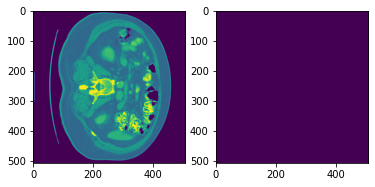

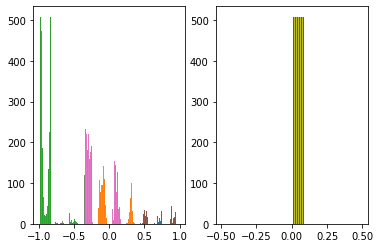

In [55]:
img_, label_, _ = prepare_img('spleen_2.nii.gz', 'spleen_22.nii.gz')

plt.figure(0)

plt.subplot(1, 2, 1)
plt.imshow(img_[0, 180, :, :])

plt.subplot(1, 2, 2)
plt.imshow(label_[0, 180, :, :])

plt.figure(1)

plt.subplot(1, 2, 1)
plt.hist(img_[0, 180, :, :])

plt.subplot(1, 2, 2)
plt.hist(label_[0, 180, :, :])